<a href="https://colab.research.google.com/github/Mustafasohail7/CUDA_Spring_2024/blob/main/Week4/RawImageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-m_m3pbyv
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-m_m3pbyv
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.0.3-py3-none-any.whl size=7432 sha256=ad99cf1e6175f37f13398802e9e82d42885745e385f9d1c2ce678f3d359f3a95
  Stored in directory: /tmp/pip-ephem-wheel-cache-7omw8u82/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Source files will be saved in "/tmp/tmph2_p_v3t".


In [2]:
#read image from our github repo
%cd /content
!wget -nc "https://github.com/mmmovania/CUDA_Spring_2024/raw/main/images/Baboon.raw"

/content
--2024-02-02 10:15:17--  https://github.com/mmmovania/CUDA_Spring_2024/raw/main/images/Baboon.raw
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mmmovania/CUDA_Spring_2024/main/images/Baboon.raw [following]
--2024-02-02 10:15:18--  https://raw.githubusercontent.com/mmmovania/CUDA_Spring_2024/main/images/Baboon.raw
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262144 (256K) [image/panasonic-raw]
Saving to: ‘Baboon.raw’

Baboon.raw          100%[===================>] 256.00K  --.-KB/s    in 0.02s   

2024-02-02 10:15:18 (12.2 MB/s) - ‘Baboon.raw’ saved [262144/262144]



In [17]:
%%cuda
#include <stdio.h>
#include <cuda.h>

const int WIDTH = 512;
const int HEIGHT = 512;
const int SIZE = WIDTH*HEIGHT;
const int IMAGE_SIZE_IN_BYTES = SIZE * sizeof(unsigned char);

void load_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "rb");
	if (fp)
	{
		fread(pData, 1, SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot open raw image.");
	}
}

void save_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "wb");
	if (fp)
	{
		fwrite(pData, 1, SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot write raw image.");
	}
}

__global__ void PictureKernel(unsigned char* d_Pin,
	unsigned char* d_Pout,
	int n, int m, float brightness = 1) {
	//Calculate the row #
	int Row = blockIdx.y*blockDim.y + threadIdx.y;

	//Calculate the column #
	int Col = blockIdx.x*blockDim.x + threadIdx.x;

	if ((Row < m) && (Col < n)) {
		int offset = (Row*n) + Col;
		int offset2 = (Row*n) + (m-Col);  //this is to flip the output image

		d_Pout[offset2] = d_Pin[offset] * brightness;
	}
}


int main(int argc, char** argv)
{
	unsigned char* host_bitmap = (unsigned char*)malloc(IMAGE_SIZE_IN_BYTES);
	unsigned char* dev_bitmap;
	unsigned char* dev_bitmap2;

	cudaMalloc(&dev_bitmap, IMAGE_SIZE_IN_BYTES);
	cudaMalloc(&dev_bitmap2, IMAGE_SIZE_IN_BYTES);

	load_raw_image("/content/Baboon.raw", host_bitmap);

	cudaMemcpy(dev_bitmap, host_bitmap, IMAGE_SIZE_IN_BYTES, cudaMemcpyHostToDevice);

	dim3    blocksGrid;
	dim3    threadsBlock(16, 16, 1);
	blocksGrid.x = ceil(WIDTH / 16.0);
	blocksGrid.y = ceil(HEIGHT / 16.0);

	PictureKernel << <blocksGrid, threadsBlock >> >(dev_bitmap, dev_bitmap2, WIDTH, HEIGHT, 0.5);

	cudaMemcpy(host_bitmap, dev_bitmap2, IMAGE_SIZE_IN_BYTES, cudaMemcpyDeviceToHost);

	save_raw_image("/content/BaboonFlipped.raw", host_bitmap);

  puts("Image saved");

	free(host_bitmap);
	cudaFree(&dev_bitmap);
	cudaFree(&dev_bitmap2);

	return 0;
}

Image saved



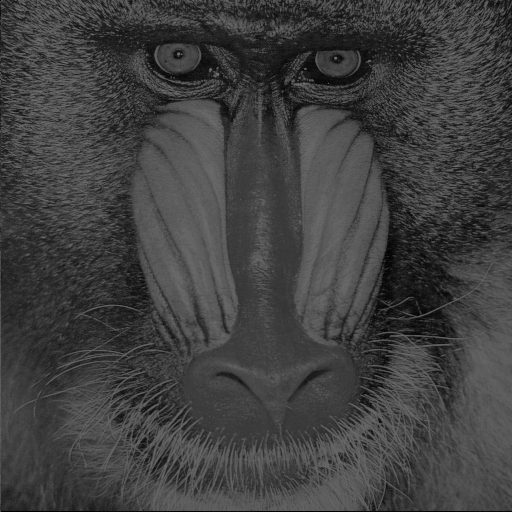

In [18]:
import numpy as np

#lets view our image
fd = open('/content/BaboonFlipped.raw', 'rb')
rows = 512
cols = 512
f = np.fromfile(fd, dtype=np.uint8,count=rows*cols)
im = f.reshape((rows, cols)) #notice row, column format
fd.close()

from google.colab.patches import cv2_imshow
#display image using cv2_imshow
cv2_imshow(im)